<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Forecasting/AWS%20Labs/DeepForecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, files
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd
from datetime import date
import os
import random
from typing import *
from progressbar import *
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Shared Funtion**

## **Data Preparation**

In [3]:
def load_and_process(data_path: str):
    data = (
        pd.read_csv(data_path, sep=",", header=0, parse_dates=['date'])
        .astype({'date': 'datetime64[ns]'})
        .assign(
            year=(lambda x: x['date'].dt.year),
            day_of_week=(lambda x: x['date'].dt.dayofweek))
    )

    data = data.loc[(data["date"] >= pd.to_datetime(date(2014, 1, 1))) &
                    (data["date"] <= pd.to_datetime(date(2014, 3, 1)))]
    data.index = pd.RangeIndex(len(data.index))  # reset index due to compare date

    # Create feature matrix
    X = np.c_[np.asarray(data['hour']), np.asarray(data['day_of_week'])]
    num_feats = X.shape[1]  # features = ['hour', 'day_of_week']
    num_periods = len(data)

    X = np.asarray(X).reshape(
        (-1, num_periods, num_feats))  # To ensure the shape of univariate series is (1, num_periods, num_feats)
    y = np.asarray(data["MT_200"]).reshape((-1, num_periods))
    return data, X, y, num_feats, num_periods

def split_train_test(X: np.array, y: np.array, split_ratio: float = 0.7):
    num_ts, num_periods, num_feats = X.shape
    train_length = int(num_periods * split_ratio)
    X_train = X[:, :train_length, :]
    y_train = y[:, :train_length]
    X_test = X[:, train_length:, :]
    y_test = y[:, train_length:]
    return X_train, y_train, X_test, y_test

def create_batch(X, y, prior, seq_len, batch_size):
    '''
    Function to create batch for training.
    For univariate case, the sampled batch will be the same repeatedly.
    For multivariate time series, the sampled batch will contain numbers of different time series
    that is equal to the batch size (for example, 64). This ensures the diversity of training; thereby
    leads to more generalizable.

    Parameters
    -----------

    X (array like): shape (num_samples, num_periods, num_features)
    y (array like): shape (num_samples, num_periods)
    piror (int)
    seq_len (int): sequence/encoder/decoder length
    '''
    num_ts, num_periods, _ = X.shape

    # If batch size is less than number of samples, using full batch. Otherwise, use batch size
    if batch_size < num_ts:
        print(f'Using full batch of size {num_ts} for training')
    else:
        print(f'Using mini-batch of size {batch_size} for training')
    batch_size = min(num_ts, batch_size)

    # Pre-calculate the range outside the choice function for efficiency
    time_range = range(prior, num_periods - seq_len)
    time_split = random.choice(time_range)

    batch_range = range(num_ts)
    batch = random.sample(batch_range, batch_size)

    # Can use empty array then store sliced values for better pre-allocation memory
    # Use slicing to get the batches
    X_train_batch = X[batch, time_split - prior :time_split, :]
    y_train_batch = y[batch, time_split - prior :time_split]

    Xf = X[batch, time_split:time_split + seq_len, :]
    yf = y[batch, time_split:time_split + seq_len]

    return X_train_batch, y_train_batch, Xf, yf

## **Scaling Data**

In [4]:
class Normalizer:
    """
    Wrapper object to perform normalization
    """
    def __init__(self):
        self.mu = None
        self.std = None

    def fit_transform(self, x):
        self.mu = np.mean(x)
        self.std = np.std(x) + 1e-4 # ddof = 1 implies sample std where ddof stands for degree of freedom
        x_normalized = (x - self.mu) / self.std

        return x_normalized

    def inverse_transform(self, x):
        return (x * self.std) + self.mu

    def transform(self, x):
        return (x - self.mu) / self.std


class MeanCenter:
    """
    Wrapper object to perform mean neutralization
    """
    def __init__(self):
        self.mu = None

    def fit_transform(self, x):
        self.mu = np.mean(x)
        return x / self.mu

    def inverse_transform(self, x):
        return x * self.mu

    def transform(self, x):
        return x / self.mu


class LogScaler:
    """
    Wrapper object to perform logarithmic scaling
    """
    def fit_transform(self, x):
        return np.log1p(x)

    def inverse_transform(self, x):
        return np.expm1(x)

    def transform(self, x):
        return np.log1p(x)

class MaxScaler:
    """
    Wrapper object to perform max neutralization
    """
    def __init__(self):
        self.max = None

    def fit_transform(self, x):
        self.max = np.max(x)
        return x / self.max

    def inverse_transform(self, x):
        return x * self.max
    def transform(self, x):
        return x / self.max

## **Likelihood Layer**

In [5]:
def Gaussian_sampling(mu, sigma):
    pdf = torch.distributions.normal.Normal(mu, sigma)
    return pdf.sample(mu.size())

def NegativeBinomial_sampling(mu, alpha):
    # Since torch does not use parameterization in the paper, we will use the conditional expection for this sample
    var = mu + mu * mu * alpha
    return mu + torch.randn(mu.size()) * torch.sqrt(var) # inject some dispersion



class Gaussian_layer(nn.Module):

    def __init__(self, hidden_size, output_size, init_weight = 'xavier'):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gaussian_layer, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)
        # self.init_weight = init_weight

        # if init_weight == 'xavier':
        #     # initialize weights
        #     nn.init.xavier_uniform_(self.mu_layer.weight)
        #     nn.init.xavier_uniform_(self.sigma_layer.weight)
        # if init_weight == 'kaiming':
        #     nn.init.kaiming_uniform_(self.mu_layer.weight)
        #     nn.init.kaiming_uniform_(self.sigma_layer.weight)

    def forward(self, hidden):
        _, hidden_size = hidden.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(hidden))) + 1e-6
        sigma_t = sigma_t.squeeze(0)
        mu_t = self.mu_layer(hidden).squeeze(0)
        return mu_t, sigma_t

class NegativeBinomial_layer(nn.Module):

    def __init__(self, hidden_size, output_size, init_weight = 'xavier'):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        hidden_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(NegativeBinomial_layer, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)
        # self.init_weight = init_weight

        # if init_weight == 'xavier':
        #     # initialize weights
        #     nn.init.xavier_uniform_(self.mu_layer.weight)
        #     nn.init.xavier_uniform_(self.sigma_layer.weight)
        # if init_weight == 'kaiming':
        #     nn.init.kaiming_uniform_(self.mu_layer.weight)
        #     nn.init.kaiming_uniform_(self.sigma_layer.weight)

    def forward(self, hidden):
        _, hidden_size = hidden.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(hidden))) + 1e-6
        # sigma_t = sigma_t.squeeze(0)
        # mu_t = self.mu_layer(hidden).squeeze(0)
        mu_t = torch.log(1 + torch.exp(self.mu_layer(hidden)))
        return mu_t, sigma_t

## **Metrics**

In [15]:
def MAPE(y,f, is_symmetric = False):
  """

  :param y: array of true values
  :param f: array of predicted values
  :param is_symmetric: If true, return the Symmetric version of MAPE (see i.e.,
  :return: Mean absolute percentage error
  """
  y = np.ravel(y) + 1e-4
  f = np.ravel(f)
  if is_symmetric:
      return 100 * np.mean(2 * np.abs((y-f) / (y+f)))
  else:
      return 100 * np.mean(np.abs((y-f)) / y)

def MAE(y, f):
    """
    :param y: array of true values
    :param f: array of predicted values
    :return: Mean Absolute Error
    """
    y = np.ravel(y)
    f = np.ravel(f)
    return np.mean(np.abs(y-f))

def MSE(y, f):
    """

    :param y: array of true values
    :param f: array of predicted values
    :return: Mean Squared Error
    """
    y = np.ravel(y)
    f = np.ravel(f)

    return np.mean((y-f)**2)

def RMSSE(y, f):
    """

    :param y: array of true values
    :param f: array of predicted values
    :return: Root Mean Scaled Squared Error
    """
    y = np.ravel(y)
    f = np.ravel(f)
    denom = np.mean((y[1:] - y[:-1]) ** 2)
    numer = MSE(y, f)

    return np.sqrt(numer / denom)

def MASE(y, f):
    """

    :param y: array of true values
    :param f: array of predicted values
    :return: Root Mean Scaled Squared Error
    """
    y = np.ravel(y)
    f = np.ravel(f)
    nom = np.sum(np.abs(f - y))
    denom = y.shape[0] / (y.shape[0] - 1) * np.sum(np.abs( y[1:] - y[:-1] ))
    loss = nom / denom
    return loss


def MQloss(y, f_samps, model = None, qs = None):
  # Compute the quantiles of the forecasts
  quantiles = []
  if qs is None:
    qs = np.arange(0, 1.01, 0.01)
  ar = (qs * 100).astype(np.int64)
  for i in ar:
    alpha = (100-i)
    # For MQRNN model, just access the dimension 2 to quantiles
    if model is not None:
      q = f_samps[:, :, i].ravel()
    else:
      q = np.percentile(f_samps, [100 - alpha], axis=1).ravel()
    quantiles.append(q)

  quantiles = np.asarray(quantiles).reshape(-1, len(ar))

  # Compute the multi-quantile loss
  # absolute error: dim (num_periods, ) \hat{y}_{t1}^{q00} - y_{t1} .... \hat{y}_{t1}^{q100} - y_{t1}
  #                                                 ...
  #                                     \hat{y}_{tN}^{q00} - y_{tN} .... \hat{y}_{tN}^{q100} - y_{tN}

  L = np.zeros_like(y.ravel()).astype(np.float64)

  y_ravel = np.swapaxes(y, 1, 0).ravel()
  for i, q in enumerate(qs):
    err = y_ravel - quantiles[:, i]
    L += np.maximum(err, np.zeros_like(err)) * (1 - q) + q * np.maximum(-err, np.zeros_like(err))

  mqloss = (1/y.shape[1]) * L.mean(axis = 0)
  return mqloss

metrics_dict = {
        'mse':MSE,
        'mase': MASE,
        'rmsse': RMSSE,
        'mape':MAPE,
        'mae':MAE,
        'mqloss': MQloss
    }

def evaluate(y, f, f_samps, model = None, metrics = ('mse','mase', 'rmsse', 'mape','mae'), return_dataframe = True):
  results = {}
  for metric in metrics:
      try:
        if metric != 'mqloss':
          y = np.ravel(y)
          f = np.ravel(f)
          results[metric] = metrics_dict[metric](y, f)
        else:
          y = np.expand_dims(y, axis = 0)
          results[metric] = metrics_dict[metric](y, f_samps, model)
      except Exception as err:
          results[metric] = np.nan
          print('Unable to compute metrics {0}: {1}'.format(metric, err))
  if return_dataframe:
    results_df = pd.DataFrame.from_dict(results.items())
    results_df.columns = ['Metric','Value']
    return results_df

  return results

## **Loss**

In [7]:
class Loss():
    def __init__(self, ytrue):
        self.ytrue = ytrue

    def gaussian_likelihood(self, mu, sigma):
        nll = torch.log(sigma + 1) + (self.ytrue - mu) ** 2 / (2 * sigma)
        return nll.mean()

    def negative_binomial_likelihood(self, mu, alpha):
        batch_size, seq_len = self.ytrue.size()
        loglik = torch.lgamma(self.ytrue + 1. / alpha) - torch.lgamma(self.ytrue + 1) - torch.lgamma(1. / alpha) - \
                 1. / alpha * torch.log(1 + alpha * mu) + self.ytrue * torch.log(alpha * mu / (1 + alpha * mu))

        return -loglik.mean()

## **Plotting**

In [8]:
def plot_data_forecast(params, y_true_plot, f_samps = None, model = None, conditional_forecast = 'mean', *args):
  fig, ax = plt.subplots(1, 1, figsize = (20, 5))
  x_values = [k + params['sequence_length'] + params['prior'] - params['sequence_length'] \
      for k in range(params['sequence_length'])]

  # Check conditions to plot forecasts of other models
  if model != 'MQRNN':
    if f_samps is None:
      raise ValueError('Need to pass `f_samps` for other forecasting models')

    if conditional_forecast == 'mean':
      f = np.mean(f_samps, axis=1)
    elif conditional_forecast == 'median':
      f = np.quantile(f_samps, 0.5, axis=1)
    else:
      raise NotImplementedError(
        f'Should be `mean` or `median` forecast, given unknown forecast type {conditional_forecast}')
    # Plot median forecast
    ax.plot(x_values, f, color="k", label=(str(conditional_forecast)).capitalize() + " forecast")

    # Plot credible intervals
    if params['probabilistic_CI']:
      ar = np.arange(0, 101, 1)
      ci_legend = "Full range of credible intervals"
    else:
      # Default 95% credible interval
      ar = [95]
      ci_legend = str(params['credible_interval']) + "% credible interval"

    for i in ar:
      alpha = (100 - i) / 2
      upper = np.percentile(f_samps, [100 - alpha], axis=1)
      lower = np.percentile(f_samps, [alpha], axis=1)
      fill = ax.fill_between(x=x_values, y1=lower.ravel(), y2=upper.ravel(), alpha=0.3, color='blue')

  # Since MQRNN not produce full probabilistic samples, we have to pass its own forecasts to plot
  else:
    y_pred = args[0] if args else None
    if y_pred is None:
      raise ValueError('Need to pass forecasts of MQRNN to plot')

    # Plot median forecast
    ax.plot(x_values, y_pred[:, :, int(np.floor(params['num_quantiles']/2))].ravel(), color="k", label="Median forecast")

    # Plot credible intervals
    ci_legend = str(params['credible_interval']) + "% credible interval"

    fill = ax.fill_between(x=x_values, y1=y_pred[:, :, 0].ravel(),
                           y2=y_pred[:, :, params['num_quantiles']-1].ravel(),
                           alpha=0.3, color='blue')

    # Add legend for credible intervals only once
    fill.set_label(ci_legend)


  # Plot observations
  yplot = y_true_plot[-1, -params['sequence_length']-params['prior']:]
  ax.scatter(range(len(yplot)), yplot, color = 'k', label="Observations")

  # Plot forecast start date
  ymin, ymax = plt.ylim()
  ax.vlines(params['sequence_length'] + params['prior'] - params['sequence_length'],
            ymin, ymax, color="green", linestyles="dashed",
            linewidth=2, label="Forecast start date")

  ax.set_ylim(ymin, ymax)
  ax.set_xlabel("Time")
  ax.set_ylabel("Y")

  # Create legend
  ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), frameon=True)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.grid(True, which='both', axis = 'y', linestyle='--', linewidth=0.5)

  plt.tight_layout()
  plt.show()

# **DeepAR**

## **Model DeepAR**

In [9]:
class DeepAR(nn.Module):
    def __init__(self, params):
        '''
        Recurrent network with lagged inputs and covariates to forecast future values
        '''
        super(DeepAR, self).__init__()
        self.params = params
        self.embedding_layer = nn.Linear(1, params['embedding_size'])
        self.lstm = nn.LSTM(input_size = params['input_size'] + params['embedding_size'],
                            hidden_size=params['lstm_hidden_size'],
                            num_layers=params['lstm_num_layers'],
                            bias = True,
                            batch_first=True,
                            dropout=params['lstm_dropout'])
        self.likelihood = params['likelihood']
        self.lr = params['lr']

        if params['data_type'] == 'continuous':
            self.likelihood_layer = Gaussian_layer(params['lstm_hidden_size'], 1)
        elif params['data_type'] == 'count':
            self.likelihood_layer = NegativeBinomial_layer(params['lstm_hidden_size'], 1)


    def forward(self, X, y, X_forecast):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            X_forecast = torch.from_numpy(X_forecast).float()

        num_ts, seq_len, _ = X.size()
        _, num_horizon, num_feats = X_forecast.size()

        y_f = None
        pred = []
        mus = []
        sigmas = []
        hidden, cell = None, None

        for t in range(seq_len + num_horizon):
            if t < seq_len:
                y_f = y[:, t].view(-1, 1) # dim (y[t], 1)
                y_embed = self.embedding_layer(y_f).view(num_ts, -1)
                x = X[:, t, :].view(num_ts, -1)
            else:
                y_embed = self.embedding_layer(y_f).view(num_ts, - 1)
                x = X_forecast[:, t - seq_len, :].view(num_ts, -1)
            x = torch.cat([x, y_embed], dim = 1) # num_ts, num_feats + embedding_dim
            lstm_input = x.unsqueeze(1) # (1, num_ts, num_feats + embedding_dim)

            if hidden is None and cell is None:
                output, (hidden, cell) = self.lstm(lstm_input)
            else:
                output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))


            hiddens = hidden[-1, :, :]
            hiddens = F.relu(hiddens)
            mu, sigma = self.likelihood_layer(hiddens)

            mus.append(mu.view(-1, 1))
            sigmas.append(sigma.view(-1, 1))

            if self.likelihood == 'continuous':
                y_f = Gaussian_sampling(mu, sigma)
            elif self.likelihood == 'count':
                alpha_curr = sigma
                mu_curr = mu
                y_f = NegativeBinomial_sampling(mu_curr, alpha_curr)

            if t >= seq_len - 1 and t < num_horizon + seq_len - 1:
                pred.append(y_f)

        pred = torch.cat(pred, dim = 1).view(num_ts, -1)
        mu_ = torch.cat(mus, dim = 1).view(num_ts, -1)
        sigma_ = torch.cat(sigmas, dim = 1).view(num_ts, -1)
        return pred, mu_, sigma_

## **Defining Parameters Dict**

In [10]:
# Define parameters dict, later add on input_size after reading the data
params = {
    'input_size': None,
    'embedding_size': 64,
    'lstm_hidden_size': 64,
    'lstm_num_layers': 3,
    'lstm_dropout': 0.,
    'likelihood': 'continuous',
    'lr': 1e-3,
    'data_type': 'continuous',
    'prior': 168,
    'sequence_length': 60,
    'batch_size': 64,
    'num_epoches': 100,
    'iter_per_epoch': 3,
    'credible_interval': 95,
    'normalize': True,
    'max_scaler': False,
    'log_scaler': False,
    'mean_center': False,
    'probabilistic_CI': False
}

full_path = '/content/drive/MyDrive/data/sample_data.csv'
data, X, y, _, _ = load_and_process(full_path)

print(X.shape)
print(y.shape)
# Update params
params['input_size'] = X.shape[2]

(1, 1440, 2)
(1, 1440)


## **Training Phase DeepAR**

In [11]:
model = DeepAR(params)
num_ts, num_periods, num_feats = X.shape
optimizer = optim.Adam(model.parameters(), lr = params['lr'])
random.seed(28)

X_train, y_train, X_test, y_test = split_train_test(X, y, split_ratio = 0.7)
losses = []
count = 0
scaler_target = None
if params['normalize']:
    scaler_target = Normalizer()
elif params['log_scaler']:
    scaler_target = LogScaler()
elif params['max_scaler']:
    scaler_target = MaxScaler()
elif params['mean_center']:
    scaler_target = MeanCenter()

if scaler_target is not None:
    y_train = scaler_target.fit_transform(y_train)

In [12]:
# training phase
progress = ProgressBar()
count = 0
for epoch in progress(range(params['num_epoches'])):
  for t in range(params['iter_per_epoch']):
    X_train_batch, y_train_batch, X_forecast, y_forecast = create_batch(X_train,
                                                                        y_train, params['prior'],
                                                                         params['sequence_length'], params['batch_size'])
    X_train_tensor, y_train_tensor = torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float()
    X_forecast_tensor, y_forecast_tensor = torch.from_numpy(X_forecast).float(), torch.from_numpy(y_forecast).float()

    ypred, mu, sigma = model(X_train_tensor, y_train_tensor, X_forecast_tensor)

    y_train_tensor = torch.cat([y_train_tensor, y_forecast_tensor], dim = 1)
    # print(y_train_tensor.size())

    if params['likelihood'] == 'continuous':
      loss_c = Loss(y_train_tensor)
      loss = loss_c.gaussian_likelihood(mu, sigma)
    elif params['likelihood'] == 'count':
      loss_c = Loss(y_train_tensor)
      loss = loss_c.negative_binomial_likelihood(mu, sigma)

    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

  # Validation
  Xtest = X_test[:, -params['sequence_length'] - params['prior']:-params['sequence_length'], :].reshape((num_ts, -1, num_feats))
  Xforecast_test = X_test[:, -params['sequence_length']:, :].reshape((num_ts, -1, num_feats))
  ytest = y_test[:, -params['sequence_length'] - params['prior']:-params['sequence_length']].reshape((num_ts, -1))
  yforecast_test = y_test[:, -params['sequence_length']:].reshape((num_ts, -1))

  if scaler_target is not None:
    ytest = scaler_target.transform(ytest)

  result = []
  n_samps = 100
  for _ in tqdm(range(n_samps)):
    y_pred, _, _ = model(Xtest, ytest, Xforecast_test)
    y_pred = y_pred.data.numpy()
    if scaler_target is not None:
      y_pred = scaler_target.inverse_transform(y_pred)
    result.append(y_pred.reshape((-1,1)))

  result = np.concatenate(result, axis=1)
  # median_forecast = np.quantile(result, 0.5, axis=1)
  # upper = np.quantile(result, 0.95, axis=1)
  # lower = np.quantile(result, 0.05, axis=1)

  # mape = MAPE(y_forecast_test, median_forecast)
  # print("Median forecast MAPE: {}".format(mape))
  # mapes.append(mape)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]
  1% (1 of 100) |                        | Elapsed Time: 0:00:50 ETA:   1:23:53

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]
  2% (2 of 100) |                        | Elapsed Time: 0:01:26 ETA:   0:58:12

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]
  3% (3 of 100) |                        | Elapsed Time: 0:02:05 ETA:   1:03:39

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:32<00:00,  3.08it/s]
  4% (4 of 100) |                        | Elapsed Time: 0:02:40 ETA:   0:56:13

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
  5% (5 of 100) |#                       | Elapsed Time: 0:03:14 ETA:   0:52:46

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]
  6% (6 of 100) |#                       | Elapsed Time: 0:03:49 ETA:   0:54:48

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]
  7% (7 of 100) |#                       | Elapsed Time: 0:04:22 ETA:   0:51:58

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]
  8% (8 of 100) |#                       | Elapsed Time: 0:04:55 ETA:   0:49:40

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]
  9% (9 of 100) |##                      | Elapsed Time: 0:05:28 ETA:   0:50:39

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.33it/s]
 10% (10 of 100) |##                     | Elapsed Time: 0:06:00 ETA:   0:47:57

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]
 11% (11 of 100) |##                     | Elapsed Time: 0:06:33 ETA:   0:49:23

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 12% (12 of 100) |##                     | Elapsed Time: 0:07:06 ETA:   0:47:29

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 13% (13 of 100) |##                     | Elapsed Time: 0:07:38 ETA:   0:46:27

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 14% (14 of 100) |###                    | Elapsed Time: 0:08:11 ETA:   0:47:45

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]
 15% (15 of 100) |###                    | Elapsed Time: 0:08:44 ETA:   0:46:06

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 16% (16 of 100) |###                    | Elapsed Time: 0:09:17 ETA:   0:46:13

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 17% (17 of 100) |###                    | Elapsed Time: 0:09:49 ETA:   0:44:05

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]
 18% (18 of 100) |####                   | Elapsed Time: 0:10:22 ETA:   0:45:15

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]
 19% (19 of 100) |####                   | Elapsed Time: 0:10:53 ETA:   0:42:32

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]
 20% (20 of 100) |####                   | Elapsed Time: 0:11:26 ETA:   0:43:11

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
 21% (21 of 100) |####                   | Elapsed Time: 0:11:58 ETA:   0:43:09

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]
 22% (22 of 100) |#####                  | Elapsed Time: 0:12:31 ETA:   0:42:11

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]
 23% (23 of 100) |#####                  | Elapsed Time: 0:13:04 ETA:   0:42:37

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
 24% (24 of 100) |#####                  | Elapsed Time: 0:13:36 ETA:   0:40:38

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 25% (25 of 100) |#####                  | Elapsed Time: 0:14:09 ETA:   0:40:53

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
 26% (26 of 100) |#####                  | Elapsed Time: 0:14:42 ETA:   0:40:57

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]
 27% (27 of 100) |######                 | Elapsed Time: 0:15:16 ETA:   0:40:48

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
 28% (28 of 100) |######                 | Elapsed Time: 0:15:47 ETA:   0:38:17

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
 29% (29 of 100) |######                 | Elapsed Time: 0:16:20 ETA:   0:38:00

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]
 30% (30 of 100) |######                 | Elapsed Time: 0:16:53 ETA:   0:39:28

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 31% (31 of 100) |#######                | Elapsed Time: 0:17:26 ETA:   0:37:38

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]
 32% (32 of 100) |#######                | Elapsed Time: 0:17:59 ETA:   0:37:25

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]
 33% (33 of 100) |#######                | Elapsed Time: 0:18:32 ETA:   0:36:23

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.17it/s]
 34% (34 of 100) |#######                | Elapsed Time: 0:19:05 ETA:   0:36:56

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 35% (35 of 100) |########               | Elapsed Time: 0:19:38 ETA:   0:34:55

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 36% (36 of 100) |########               | Elapsed Time: 0:20:10 ETA:   0:34:51

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
 37% (37 of 100) |########               | Elapsed Time: 0:20:43 ETA:   0:34:16

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 38% (38 of 100) |########               | Elapsed Time: 0:21:16 ETA:   0:33:52

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 39% (39 of 100) |########               | Elapsed Time: 0:21:48 ETA:   0:33:04

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]
 40% (40 of 100) |#########              | Elapsed Time: 0:22:20 ETA:   0:31:49

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
 41% (41 of 100) |#########              | Elapsed Time: 0:22:53 ETA:   0:32:46

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 42% (42 of 100) |#########              | Elapsed Time: 0:23:26 ETA:   0:31:20

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
 43% (43 of 100) |#########              | Elapsed Time: 0:23:59 ETA:   0:31:35

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
 44% (44 of 100) |##########             | Elapsed Time: 0:24:31 ETA:   0:30:03

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 45% (45 of 100) |##########             | Elapsed Time: 0:25:04 ETA:   0:30:08

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 46% (46 of 100) |##########             | Elapsed Time: 0:25:36 ETA:   0:29:03

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 47% (47 of 100) |##########             | Elapsed Time: 0:26:08 ETA:   0:28:17

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 48% (48 of 100) |###########            | Elapsed Time: 0:26:41 ETA:   0:28:26

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 49% (49 of 100) |###########            | Elapsed Time: 0:27:14 ETA:   0:27:28

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]
 50% (50 of 100) |###########            | Elapsed Time: 0:27:47 ETA:   0:27:34

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
 51% (51 of 100) |###########            | Elapsed Time: 0:28:18 ETA:   0:25:53

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]
 52% (52 of 100) |###########            | Elapsed Time: 0:28:51 ETA:   0:26:26

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]
 53% (53 of 100) |############           | Elapsed Time: 0:29:26 ETA:   0:26:44

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.39it/s]
 54% (54 of 100) |############           | Elapsed Time: 0:29:57 ETA:   0:24:03

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]
 55% (55 of 100) |############           | Elapsed Time: 0:30:29 ETA:   0:24:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]
 56% (56 of 100) |############           | Elapsed Time: 0:31:01 ETA:   0:23:22

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]
 57% (57 of 100) |#############          | Elapsed Time: 0:31:34 ETA:   0:23:36

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 58% (58 of 100) |#############          | Elapsed Time: 0:32:07 ETA:   0:22:35

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]
 59% (59 of 100) |#############          | Elapsed Time: 0:32:40 ETA:   0:22:38

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 60% (60 of 100) |#############          | Elapsed Time: 0:33:12 ETA:   0:21:49

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]
 61% (61 of 100) |##############         | Elapsed Time: 0:33:44 ETA:   0:20:42

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 62% (62 of 100) |##############         | Elapsed Time: 0:34:17 ETA:   0:20:59

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
 63% (63 of 100) |##############         | Elapsed Time: 0:34:50 ETA:   0:20:00

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]
 64% (64 of 100) |##############         | Elapsed Time: 0:35:22 ETA:   0:19:30

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 65% (65 of 100) |##############         | Elapsed Time: 0:35:54 ETA:   0:18:39

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]
 66% (66 of 100) |###############        | Elapsed Time: 0:36:26 ETA:   0:18:04

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 67% (67 of 100) |###############        | Elapsed Time: 0:36:59 ETA:   0:18:10

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]
 68% (68 of 100) |###############        | Elapsed Time: 0:37:31 ETA:   0:16:56

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]
 69% (69 of 100) |###############        | Elapsed Time: 0:38:04 ETA:   0:17:10

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
 70% (70 of 100) |################       | Elapsed Time: 0:38:37 ETA:   0:16:13

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
 71% (71 of 100) |################       | Elapsed Time: 0:39:10 ETA:   0:16:04

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
 72% (72 of 100) |################       | Elapsed Time: 0:39:42 ETA:   0:14:48

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.36it/s]
 73% (73 of 100) |################       | Elapsed Time: 0:40:13 ETA:   0:14:14

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]
 74% (74 of 100) |#################      | Elapsed Time: 0:40:47 ETA:   0:14:24

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]
 75% (75 of 100) |#################      | Elapsed Time: 0:41:19 ETA:   0:13:16

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.25it/s]
 76% (76 of 100) |#################      | Elapsed Time: 0:41:51 ETA:   0:13:03

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]
 77% (77 of 100) |#################      | Elapsed Time: 0:42:24 ETA:   0:12:26

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]
 78% (78 of 100) |#################      | Elapsed Time: 0:42:57 ETA:   0:12:05

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
 79% (79 of 100) |##################     | Elapsed Time: 0:43:29 ETA:   0:11:23

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]
 80% (80 of 100) |##################     | Elapsed Time: 0:44:01 ETA:   0:10:41

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
 81% (81 of 100) |##################     | Elapsed Time: 0:44:35 ETA:   0:10:46

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]
 82% (82 of 100) |##################     | Elapsed Time: 0:45:07 ETA:   0:09:34

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]
 83% (83 of 100) |###################    | Elapsed Time: 0:45:41 ETA:   0:09:29

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
 84% (84 of 100) |###################    | Elapsed Time: 0:46:13 ETA:   0:08:38

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.19it/s]
 85% (85 of 100) |###################    | Elapsed Time: 0:46:46 ETA:   0:08:20

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]
 86% (86 of 100) |###################    | Elapsed Time: 0:47:18 ETA:   0:07:27

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 87% (87 of 100) |####################   | Elapsed Time: 0:47:51 ETA:   0:06:58

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]
 88% (88 of 100) |####################   | Elapsed Time: 0:48:23 ETA:   0:06:31

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]
 89% (89 of 100) |####################   | Elapsed Time: 0:48:56 ETA:   0:06:00

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
 90% (90 of 100) |####################   | Elapsed Time: 0:49:29 ETA:   0:05:30

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]
 91% (91 of 100) |####################   | Elapsed Time: 0:50:01 ETA:   0:04:47

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]
 92% (92 of 100) |#####################  | Elapsed Time: 0:50:34 ETA:   0:04:23

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
 93% (93 of 100) |#####################  | Elapsed Time: 0:51:06 ETA:   0:03:47

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
 94% (94 of 100) |#####################  | Elapsed Time: 0:51:38 ETA:   0:03:11

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
 95% (95 of 100) |#####################  | Elapsed Time: 0:52:11 ETA:   0:02:44

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.29it/s]
 96% (96 of 100) |###################### | Elapsed Time: 0:52:44 ETA:   0:02:10

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]
 97% (97 of 100) |###################### | Elapsed Time: 0:53:17 ETA:   0:01:39

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]
 98% (98 of 100) |###################### | Elapsed Time: 0:53:49 ETA:   0:01:03

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]
 99% (99 of 100) |###################### | Elapsed Time: 0:54:22 ETA:   0:00:33

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
100% (100 of 100) |######################| Elapsed Time: 0:54:54 Time:  0:54:54


## **Evaluation**

In [13]:
alpha = (100 - params['credible_interval']) / 2
median_forecast = np.median(result, axis=1)
upper = np.percentile(result, [100-alpha], axis=1)
lower = np.percentile(result, [alpha], axis = 1)

In [16]:
result_deepar = evaluate(yforecast_test, median_forecast, result)
result_deepar['Model'] = 'Deep AR'

In [18]:
result_deepar

,Metric,Value,Model
0,mse,83014.587531,Deep AR
1,mase,0.966540,Deep AR
2,rmsse,0.992570,Deep AR
3,mape,7.373291,Deep AR
4,mae,204.955897,Deep AR


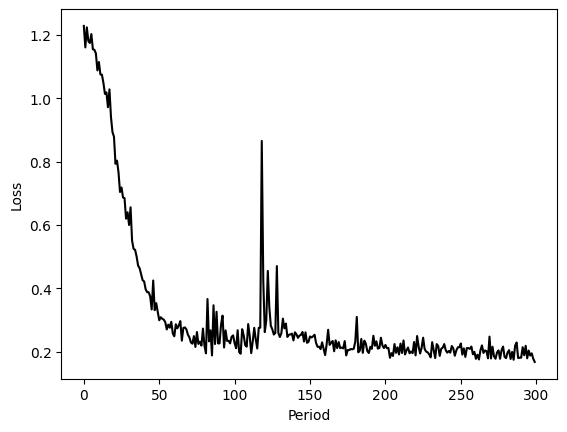

In [19]:
plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

## **Plotting Forecasts**

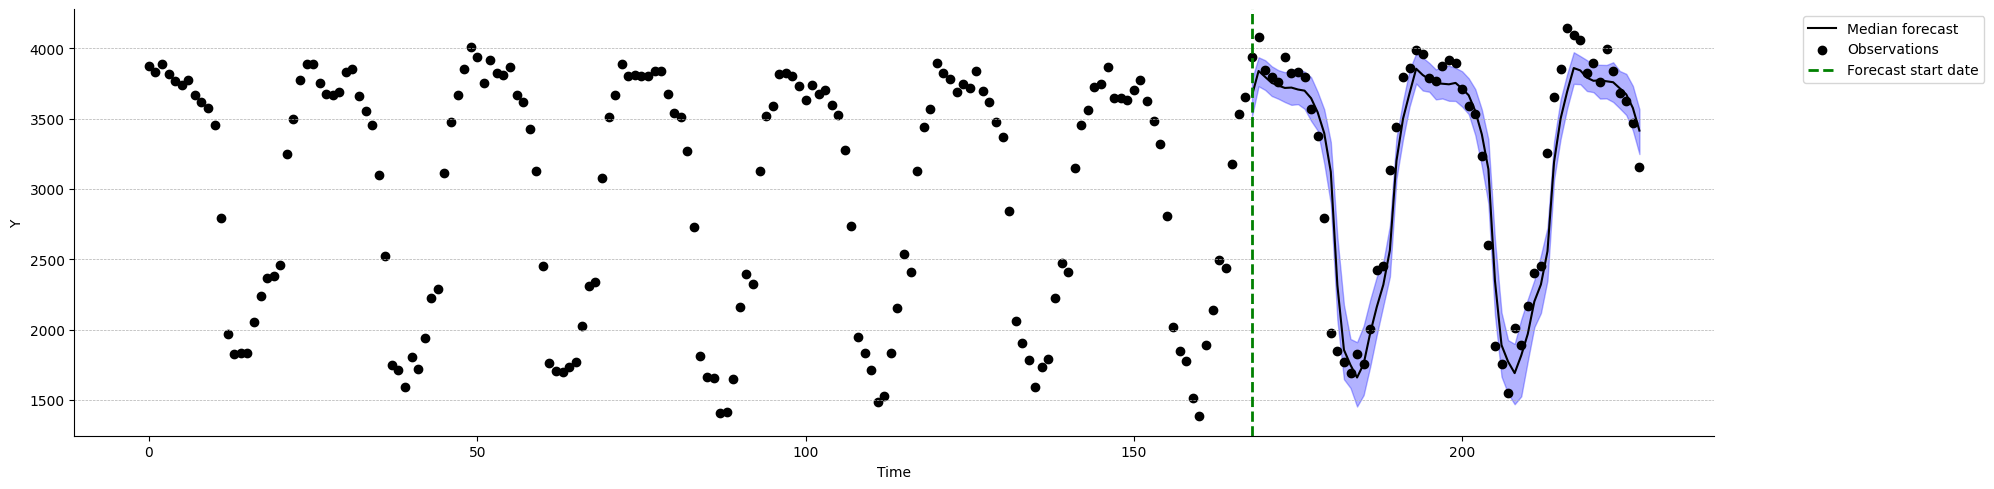

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [20]:
y_true_plot = y_test
DeepARfig = plot_data_forecast(params, y_true_plot, result, conditional_forecast = 'median')
plt.savefig("DeepAR.pdf", bbox_inches='tight')
files.download("DeepAR.pdf")

# **Deep Factors**

## **Model Deep Factors**

In [21]:
class NoiseRNN(nn.Module):
    """
    Generates noise from RNN architecture that takes input features.
    """
    def __init__(self, params):
        super(NoiseRNN, self).__init__()
        self.rnn_cell = nn.LSTM(params['input_size'], params['noise_hidden_size'],
                                params['noise_num_layers'], bias = True, batch_first=True)
        self.affine_transform = nn.Linear(params['noise_hidden_size'], 1)

    def forward(self, X):
        num_ts, num_feats = X.shape
        X = X.unsqueeze(1)
        _, (hidden, cell) = self.rnn_cell(X)
        hiddens = hidden[-1, :, :] # dim (num_ts, random effects)
        hiddens = F.relu(hiddens)
        sigma_t = self.affine_transform(hiddens)
        sigma_t = torch.log(1 + torch.exp(sigma_t)) # Sofplus to make sure sigma_t is positive
        return sigma_t.view(-1, 1)

class GlobalFactor(nn.Module):
    """
    Generates global effects (fixed effects or common patterns) modelled by RNNs
    given the input features. Later this will play as pivotal
    components in the linear combination of deep factors.
    """
    def __init__(self, params):
        super(GlobalFactor, self).__init__()
        self.rnn_cell = nn.LSTM(params['input_size'], params['global_hidden_size'],
                                params['global_num_layers'],
                                bias = True, batch_first=True)
        self.latent_deep_factor = nn.Linear(params['global_hidden_size'], params['global_num_factors'])

    def forward(self, X):
        num_ts, num_feats = X.shape
        X = X.unsqueeze(1)
        _, (hidden, cell) = self.rnn_cell(X)
        hiddens = hidden[-1, :, :]  # dim (num_ts, global effects)
        hiddens = F.relu(hiddens)
        gt = hiddens
        return gt.view(num_ts, -1)

class DeepFactorRNN(nn.Module):
    def __init__(self, params):
        super(DeepFactorRNN, self).__init__()
        self.generate_noise = NoiseRNN(params)
        self.global_factor = GlobalFactor(params)
        self.affine = nn.Linear(params['global_hidden_size'], params['global_num_factors'])

    def forward(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()
        num_ts, num_periods, num_feats = X.size()
        mus = []
        sigmas = []
        for t in range(num_periods):
            global_factor_t = self.global_factor(X[:, t, :])
            fixed_effect_t  = self.affine(global_factor_t)
            fixed_effect_t = fixed_effect_t.sum(dim = 1).view(-1, 1)
            sigma_t = self.generate_noise(X[:, t, :])
            mus.append(fixed_effect_t)
            sigmas.append(sigma_t)
        mus = torch.cat(mus, dim = 1).view(num_ts, num_periods)
        sigmas = torch.cat(sigmas, dim = 1).view(num_ts, num_periods) + 1e-6 # prevent nonnegative
        return mus, sigmas

    def sample(self, X, num_samps = 100):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()

        mu, sigma = self.forward(X)
        num_ts, num_periods = mu.size()
        z = torch.zeros(num_ts, num_periods)
        for _ in range(num_samps):
            likelihood = torch.distributions.normal.Normal(loc = mu, scale = sigma)
            z_samp = likelihood.sample().view(num_ts, num_periods)
            z += z_samp

        z = z / num_samps
        return z

## **Defining Parameters Dict**

In [22]:
# Define parameters dict, later add on input_size after reading the data
params = {
    'input_size': None,
    'num_layers': 3,
    'global_hidden_size': 64,
    'noise_hidden_size': 6,
    'global_num_layers': 3,
    'noise_num_layers': 1,
    'global_num_factors': 10,
    'lr': 1e-3,
    'prior': 168,
    'sequence_length': 60,
    'batch_size': 64,
    'num_epoches': 100,
    'iter_per_epoch': 3,
    'credible_interval': 95,
    'likelihood': 'continuous',
    'normalize': True,
    'max_scaler': False,
    'log_scaler': False,
    'mean_center': False,
    'probabilistic_CI': False
}

full_path = '/content/drive/MyDrive/data/sample_data.csv'
data, X, y, _, _ = load_and_process(full_path)

print(X.shape)
print(y.shape)
# Update params
params['input_size'] = X.shape[2]

(1, 1440, 2)
(1, 1440)


## **Training Phase Deep Factors**

In [23]:
model = DeepFactorRNN(params)
num_ts, num_periods, num_feats = X.shape
optimizer = optim.Adam(model.parameters(), lr = params['lr'])
random.seed(28)

X_train, y_train, X_test, y_test = split_train_test(X, y)
losses = []
count = 0
scaler_target = None
if params['normalize']:
    scaler_target = Normalizer()
elif params['log_scaler']:
    scaler_target = LogScaler()
elif params['max_scaler']:
    scaler_target = MaxScaler()
elif params['mean_center']:
    scaler_target = MeanCenter()

if scaler_target is not None:
    y_train = scaler_target.fit_transform(y_train)

In [24]:
# training phase
progress = ProgressBar()
count = 0
for epoch in progress(range(params['num_epoches'])):
  for t in range(params['iter_per_epoch']):
    X_train_batch, y_train_batch, X_forecast, y_forecast = create_batch(X_train, y_train, params['prior'],
                                                                            params['sequence_length'], params['batch_size'])
    X_train_tensor, y_train_tensor = torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float()
    X_forecast_tensor, y_forecast_tensor = torch.from_numpy(X_forecast).float(), torch.from_numpy(y_forecast).float()

    mu, sigma = model(X_train_tensor)
    print(mu.size())
    print(sigma.size())

    if params['likelihood'] == 'continuous':
      loss_c = Loss(y_train_tensor)
      loss = loss_c.gaussian_likelihood(mu, sigma)
    elif params['likelihood'] == 'count':
      loss_c = Loss(y_train_tensor)
      loss = loss_c.negative_binomial_likelihood(mu, sigma)

    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

# Validation
Xtest = X_test[:, -params['sequence_length'] - params['prior']:-params['sequence_length'], :].reshape((num_ts, -1, num_feats))
Xforecast_test = X_test[:, -params['sequence_length']:, :].reshape((num_ts, -1, num_feats))
ytest = y_test[:, -params['sequence_length'] - params['prior']:-params['sequence_length']].reshape((num_ts, -1))
yforecast_test = y_test[:, -params['sequence_length']:].reshape((num_ts, -1))

if scaler_target is not None:
  ytest = scaler_target.transform(ytest)

result = []
n_samps = 100
for _ in tqdm(range(n_samps)):
  y_pred = model.sample(Xforecast_test)
  y_pred = y_pred.data.numpy()
  if scaler_target is not None:
    y_pred = scaler_target.inverse_transform(y_pred)
    # print(y_pred.shape)
  result.append(y_pred.reshape((-1,1))) # dim (num_periods, 1)

result = np.concatenate(result, axis=1) # dim (num_periods, num_samps)

alpha = (100 - params['credible_interval']) / 2
median_forecast = np.median(result, axis=1)
upper = np.percentile(result, [100-alpha], axis=1)
lower = np.percentile(result, [alpha], axis = 1)
# median_forecast = np.quantile(result, 0.5, axis=1)
# upper = np.quantile(result, 0.975, axis=1)
# lower = np.quantile(result, 0.025, axis=1)
# mape = MAPE(y_forecast_test, median_forecast)
# print("Median forecast MAPE: {}".format(mape))
# mapes.append(mape)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  1% (1 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:03:26

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  2% (2 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:03:28

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  3% (3 of 100) |                        | Elapsed Time: 0:00:06 ETA:   0:03:11

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  4% (4 of 100) |                        | Elapsed Time: 0:00:07 ETA:   0:02:45

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  5% (5 of 100) |#                       | Elapsed Time: 0:00:09 ETA:   0:02:38

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  6% (6 of 100) |#                       | Elapsed Time: 0:00:11 ETA:   0:02:38

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  7% (7 of 100) |#                       | Elapsed Time: 0:00:12 ETA:   0:02:33

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  8% (8 of 100) |#                       | Elapsed Time: 0:00:14 ETA:   0:02:26

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


  9% (9 of 100) |##                      | Elapsed Time: 0:00:16 ETA:   0:02:35

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 10% (10 of 100) |##                     | Elapsed Time: 0:00:18 ETA:   0:03:19

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 11% (11 of 100) |##                     | Elapsed Time: 0:00:20 ETA:   0:03:00

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 12% (12 of 100) |##                     | Elapsed Time: 0:00:21 ETA:   0:02:39

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 13% (13 of 100) |##                     | Elapsed Time: 0:00:23 ETA:   0:02:16

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 14% (14 of 100) |###                    | Elapsed Time: 0:00:25 ETA:   0:02:13

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 15% (15 of 100) |###                    | Elapsed Time: 0:00:26 ETA:   0:02:10

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 16% (16 of 100) |###                    | Elapsed Time: 0:00:28 ETA:   0:02:12

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 17% (17 of 100) |###                    | Elapsed Time: 0:00:29 ETA:   0:02:19

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 18% (18 of 100) |####                   | Elapsed Time: 0:00:32 ETA:   0:03:07

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 19% (19 of 100) |####                   | Elapsed Time: 0:00:34 ETA:   0:02:47

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 20% (20 of 100) |####                   | Elapsed Time: 0:00:36 ETA:   0:02:32

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 21% (21 of 100) |####                   | Elapsed Time: 0:00:37 ETA:   0:02:11

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:39 ETA:   0:02:09

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:41 ETA:   0:02:11

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:42 ETA:   0:02:04

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:44 ETA:   0:02:05

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:46 ETA:   0:02:48

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 27% (27 of 100) |######                 | Elapsed Time: 0:00:49 ETA:   0:03:09

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 28% (28 of 100) |######                 | Elapsed Time: 0:00:50 ETA:   0:02:31

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 29% (29 of 100) |######                 | Elapsed Time: 0:00:52 ETA:   0:01:53

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 30% (30 of 100) |######                 | Elapsed Time: 0:00:54 ETA:   0:01:54

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 31% (31 of 100) |#######                | Elapsed Time: 0:00:55 ETA:   0:01:55

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 32% (32 of 100) |#######                | Elapsed Time: 0:00:57 ETA:   0:01:52

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 33% (33 of 100) |#######                | Elapsed Time: 0:00:59 ETA:   0:01:57

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 34% (34 of 100) |#######                | Elapsed Time: 0:01:01 ETA:   0:02:38

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 35% (35 of 100) |########               | Elapsed Time: 0:01:03 ETA:   0:02:17

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 36% (36 of 100) |########               | Elapsed Time: 0:01:05 ETA:   0:01:52

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 37% (37 of 100) |########               | Elapsed Time: 0:01:06 ETA:   0:01:46

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 38% (38 of 100) |########               | Elapsed Time: 0:01:08 ETA:   0:01:45

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 39% (39 of 100) |########               | Elapsed Time: 0:01:10 ETA:   0:01:40

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 40% (40 of 100) |#########              | Elapsed Time: 0:01:11 ETA:   0:01:35

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 41% (41 of 100) |#########              | Elapsed Time: 0:01:13 ETA:   0:01:43

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 42% (42 of 100) |#########              | Elapsed Time: 0:01:16 ETA:   0:02:22

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 43% (43 of 100) |#########              | Elapsed Time: 0:01:18 ETA:   0:02:02

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 44% (44 of 100) |##########             | Elapsed Time: 0:01:19 ETA:   0:01:39

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 45% (45 of 100) |##########             | Elapsed Time: 0:01:21 ETA:   0:01:31

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 46% (46 of 100) |##########             | Elapsed Time: 0:01:22 ETA:   0:01:27

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 47% (47 of 100) |##########             | Elapsed Time: 0:01:24 ETA:   0:01:25

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 48% (48 of 100) |###########            | Elapsed Time: 0:01:26 ETA:   0:01:21

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 49% (49 of 100) |###########            | Elapsed Time: 0:01:28 ETA:   0:01:46

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 50% (50 of 100) |###########            | Elapsed Time: 0:01:30 ETA:   0:01:58

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 51% (51 of 100) |###########            | Elapsed Time: 0:01:32 ETA:   0:01:42

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 52% (52 of 100) |###########            | Elapsed Time: 0:01:34 ETA:   0:01:24

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 53% (53 of 100) |############           | Elapsed Time: 0:01:35 ETA:   0:01:20

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 54% (54 of 100) |############           | Elapsed Time: 0:01:37 ETA:   0:01:16

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 55% (55 of 100) |############           | Elapsed Time: 0:01:39 ETA:   0:01:15

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 56% (56 of 100) |############           | Elapsed Time: 0:01:40 ETA:   0:01:13

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 57% (57 of 100) |#############          | Elapsed Time: 0:01:43 ETA:   0:01:40

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 58% (58 of 100) |#############          | Elapsed Time: 0:01:45 ETA:   0:01:36

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 59% (59 of 100) |#############          | Elapsed Time: 0:01:47 ETA:   0:01:20

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 60% (60 of 100) |#############          | Elapsed Time: 0:01:48 ETA:   0:01:05

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 61% (61 of 100) |##############         | Elapsed Time: 0:01:50 ETA:   0:01:02

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 62% (62 of 100) |##############         | Elapsed Time: 0:01:51 ETA:   0:00:58

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 63% (63 of 100) |##############         | Elapsed Time: 0:01:53 ETA:   0:00:58

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 64% (64 of 100) |##############         | Elapsed Time: 0:01:55 ETA:   0:01:00

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 65% (65 of 100) |##############         | Elapsed Time: 0:01:57 ETA:   0:01:14

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 66% (66 of 100) |###############        | Elapsed Time: 0:01:59 ETA:   0:01:13

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 67% (67 of 100) |###############        | Elapsed Time: 0:02:01 ETA:   0:01:04

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 68% (68 of 100) |###############        | Elapsed Time: 0:02:02 ETA:   0:00:54

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 69% (69 of 100) |###############        | Elapsed Time: 0:02:04 ETA:   0:00:50

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 70% (70 of 100) |################       | Elapsed Time: 0:02:06 ETA:   0:00:48

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 71% (71 of 100) |################       | Elapsed Time: 0:02:07 ETA:   0:00:47

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 72% (72 of 100) |################       | Elapsed Time: 0:02:09 ETA:   0:00:46

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 73% (73 of 100) |################       | Elapsed Time: 0:02:11 ETA:   0:00:54

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 74% (74 of 100) |#################      | Elapsed Time: 0:02:13 ETA:   0:00:56

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 75% (75 of 100) |#################      | Elapsed Time: 0:02:15 ETA:   0:00:49

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 76% (76 of 100) |#################      | Elapsed Time: 0:02:16 ETA:   0:00:40

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 77% (77 of 100) |#################      | Elapsed Time: 0:02:18 ETA:   0:00:36

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 78% (78 of 100) |#################      | Elapsed Time: 0:02:20 ETA:   0:00:36

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 79% (79 of 100) |##################     | Elapsed Time: 0:02:21 ETA:   0:00:34

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 80% (80 of 100) |##################     | Elapsed Time: 0:02:23 ETA:   0:00:31

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 81% (81 of 100) |##################     | Elapsed Time: 0:02:25 ETA:   0:00:31

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 82% (82 of 100) |##################     | Elapsed Time: 0:02:27 ETA:   0:00:40

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 83% (83 of 100) |###################    | Elapsed Time: 0:02:29 ETA:   0:00:34

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 84% (84 of 100) |###################    | Elapsed Time: 0:02:31 ETA:   0:00:28

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 85% (85 of 100) |###################    | Elapsed Time: 0:02:32 ETA:   0:00:24

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 86% (86 of 100) |###################    | Elapsed Time: 0:02:34 ETA:   0:00:22

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 87% (87 of 100) |####################   | Elapsed Time: 0:02:36 ETA:   0:00:28

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 88% (88 of 100) |####################   | Elapsed Time: 0:02:38 ETA:   0:00:23

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 89% (89 of 100) |####################   | Elapsed Time: 0:02:40 ETA:   0:00:23

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 90% (90 of 100) |####################   | Elapsed Time: 0:02:42 ETA:   0:00:23

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 91% (91 of 100) |####################   | Elapsed Time: 0:02:44 ETA:   0:00:18

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 92% (92 of 100) |#####################  | Elapsed Time: 0:02:45 ETA:   0:00:13

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 93% (93 of 100) |#####################  | Elapsed Time: 0:02:47 ETA:   0:00:10

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 94% (94 of 100) |#####################  | Elapsed Time: 0:02:48 ETA:   0:00:08

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 95% (95 of 100) |#####################  | Elapsed Time: 0:02:50 ETA:   0:00:07

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 96% (96 of 100) |###################### | Elapsed Time: 0:02:52 ETA:   0:00:06

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 97% (97 of 100) |###################### | Elapsed Time: 0:02:54 ETA:   0:00:05

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 98% (98 of 100) |###################### | Elapsed Time: 0:02:56 ETA:   0:00:04

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


 99% (99 of 100) |###################### | Elapsed Time: 0:02:58 ETA:   0:00:02

Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])
Using mini-batch of size 64 for training
torch.Size([1, 168])
torch.Size([1, 168])


100% (100 of 100) |######################| Elapsed Time: 0:03:01 Time:  0:03:01
100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


## **Testing Multi-quantile loss**

In [25]:
# quantiles = []
# ar = np.arange(0, 101, 1)
# for i in ar:
#   alpha = (100-i)
#   q = np.percentile(result, [100 - alpha], axis=1).ravel()
#   quantiles.append(q)

# quantiles = np.asarray(quantiles)

In [26]:
# # Compute the quantiles of the forecasts
# quantiles = []
# ar = np.arange(0, 101, 1)
# for i in ar:
#   alpha = (100-i)
#   q = np.percentile(result, [100 - alpha], axis=1).ravel()
#   quantiles.append(q)
# quantiles = np.asarray(quantiles).reshape(-1, len(ar))

# # Compute the multi-quantile loss
# # absolute error: dim (num_periods, ) \hat{y}_{t1}^{q00} - y_{t1} .... \hat{y}_{t1}^{q100} - y_{t1}
# #                                                 ...
# #                                     \hat{y}_{tN}^{q00} - y_{tN} .... \hat{y}_{tN}^{q100} - y_{tN}

# qs = np.arange(0, 1.01, 0.01)
# L = np.zeros_like(y_forecast_test.ravel()).astype(np.float64)
# for i, q in enumerate(qs):
#   err = np.swapaxes(y_forecast_test, 1, 0).ravel() - quantiles[:, i]
#   L += np.maximum(err, np.zeros_like(err)) * (1 - q) + q * np.maximum(-err, np.zeros_like(err))

# mqloss = (1/y_forecast_test.shape[1]) * L.mean(axis = 0)

## **Evaluation**

In [27]:
alpha = (100 - params['credible_interval']) / 2
median_forecast = np.median(result, axis=1)
result_deepfactor = evaluate(yforecast_test, median_forecast, result)
result_deepfactor['Model'] = 'Deep Factor'

In [28]:
result_deepfactor

,Metric,Value,Model
0,mse,27032.847683,Deep Factor
1,mase,0.625958,Deep Factor
2,rmsse,0.566409,Deep Factor
3,mape,4.384458,Deep Factor
4,mae,132.735021,Deep Factor


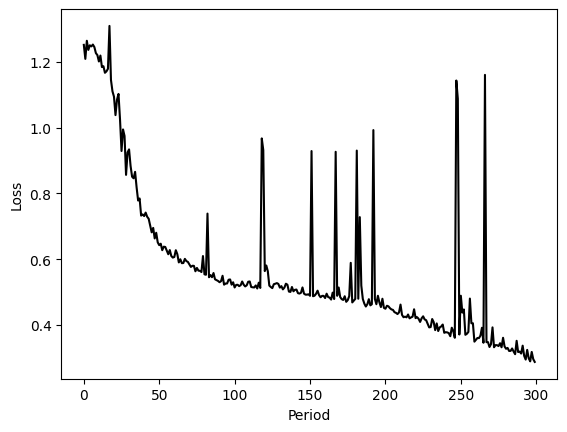

In [29]:
#title Default title text
plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

## **Plotting Forecasts**




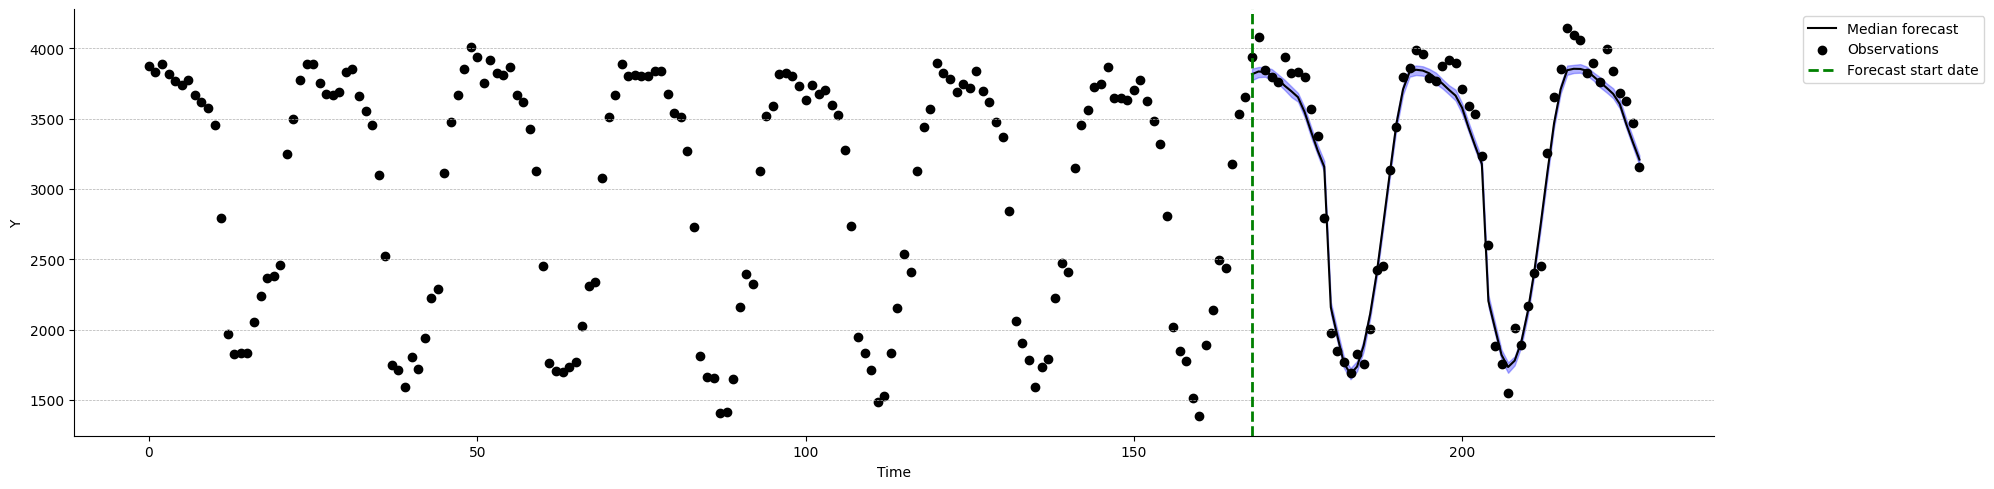

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [30]:
y_true_plot = np.hstack((scaler_target.inverse_transform(ytest), yforecast_test))
# upper = np.quantile(result, 0.975, axis=1)
# lower = np.quantile(result, 0.025, axis=1)
Deepfactorfig = plot_data_forecast(params, y_true_plot, result, conditional_forecast = 'median')
# plt.savefig("Deepfactor.pdf", bbox_inches='tight')
# files.download("Deepfactor.pdf")

# **MQ-RNN**


## **Model MQ-RNN**

In [31]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Decoder(nn.Module):
  def __init__(self, input_size,
        output_horizon,
        encoder_hidden_size,
        decoder_hidden_size,
        output_size):
    super(Decoder, self).__init__()
    self.global_mlp = nn.Linear(output_horizon * (encoder_hidden_size + input_size), \
              (output_horizon+1) * decoder_hidden_size)
    self.local_mlp = nn.Linear(decoder_hidden_size + input_size + 1, output_size)
    self.decoder_hidden_size = decoder_hidden_size

  def forward(self, hidden_t, X_forecast):
    """
    hidden_t: (1, hidden_size)
    X_forecast: (1, output_horizon, num_features)
    """
    num_ts, output_horizon, num_feats = X_forecast.size()
    num_ts, hidden_size = hidden_t.size() # (1, hidden_size)

    hidden_t = hidden_t.unsqueeze(1) # (1, 1, hidden_size)
    hidden_t = hidden_t.expand(num_ts, output_horizon, hidden_size)

    # Concatentate future covariates and last hidden states from encoder
    concat_input = torch.cat([X_forecast, hidden_t], dim = 2).view(num_ts, -1)

    contextual_input = self.global_mlp(concat_input)
    contextual_input = contextual_input.view(num_ts, output_horizon + 1, self.decoder_hidden_size)

    contextual_input_t = contextual_input[:, -1, :].view(num_ts, -1)
    contextual_input_final = contextual_input_t[:, :-1]
    contextual_input_final = F.relu(contextual_input_final)

    y = []
    for i in range(output_horizon):
        contextual_input_ = contextual_input_final[:, i].view(num_ts, -1)
        # print(f'contextual_input_ shape: {contextual_input_.size()}')
        X_forecast_ = X_forecast[:, i, :].view(num_ts, -1)
        # print(f'X_forecast_ shape: {X_forecast_.size()}')
        concat_input = torch.cat([X_forecast_, contextual_input_, contextual_input_t], dim = 1)
        # print(f'concat_input shape: {concat_input.size()}')
        out = self.local_mlp(concat_input) # (num_ts, num_quantiles)

        y.append(out.unsqueeze(1)) # (num_ts, 1, num_quantiles)

    y = torch.cat(y, dim = 1) # (num_ts/batch_size, output_horizon ,num_quantiles)
    return y


class MQRNN(nn.Module):
    def __init__(self, params):
        """
        Parameters
        ----------

        output_horizon (int): output horizons to output in prediction
        num_quantiles (int): number of quantiles interests, e.g. 0.25, 0.5, 0.75
        input_size (int): feature size
        embedding_size (int): embedding size
        encoder_hidden_size (int): hidden size in encoder
        encoder_n_layers (int): encoder number of layers
        decoder_hidden_size (int): hidden size in decoder
        """
        super(MQRNN, self).__init__()
        self.output_horizon = params['output_horizon']
        self.encoder_hidden_size = params['encoder_hidden_size']
        self.embed_layer = nn.Linear(1, params['embedding_size'])  # time series embedding
        self.encoder = nn.LSTM(params['input_size'] + params['embedding_size'], params['encoder_hidden_size'], \
                               params['num_layers'], bias=True, batch_first=True)
        self.decoder = Decoder(params['input_size'], params['output_horizon'], params['encoder_hidden_size'], \
                               params['decoder_hidden_size'], params['num_quantiles'])

    def forward(self, X, y, X_forecast):
        """
        Parameters
        ----------
        X: (num_ts, num_periods, num_feats)
        y: (num_ts, num_periods)
        X_forecast: (num_ts, seq_len, num_feats)
        """

        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            X_forecast = torch.from_numpy(X_forecast).float()

        num_ts, num_periods, num_feats = X.size()
        y = y.unsqueeze(2) # (num_ts, num_periods, 1)
        y = self.embed_layer(y)
        x = torch.cat([X, y], dim = 2)

        _, (h, c) = self.encoder(x)
        hidden_t = h[-1, :, :]

        hidden_t = F.relu(hidden_t)
        y_pred = self.decoder(hidden_t, X_forecast)
        return y_pred


## **Defining Parameters Dict**

In [32]:
# Define parameters dict, later add on input_size after reading the data
params = {
    'input_size': None,
    'quantiles': [0.025, 0.5, 0.975],
    'num_quantiles': None,
    'num_layers': 3,
    'encoder_hidden_size': 64,
    'decoder_hidden_size': 64,
    'embedding_size': 10,
    'lr': 1e-3,
    'prior': 168,
    'output_horizon': 60,
    'sequence_length': 60,
    'batch_size': 64,
    'num_epoches': 100,
    'iter_per_epoch': 3,
    'credible_interval': 95,
    'normalize': True,
    'max_scaler': False,
    'log_scaler': False,
    'mean_center': False,
    'probabilistic_CI': False
}

# data_path = os.path.join(os.getcwd(), 'data')
# full_path = os.path.join(data_path, "LD_MT200_hour.txt")

full_path = '/content/drive/MyDrive/data/sample_data.csv'
data, X, y, _, _ = load_and_process(full_path)

print(X.shape)
print(y.shape)
# Update params
params['input_size'] = X.shape[2]
num_quantiles = len(params['quantiles'])
params['num_quantiles'] = num_quantiles

(1, 1440, 2)
(1, 1440)


## **Training Phase MQ-RNN**

In [33]:
model = MQRNN(params)
num_ts, num_periods, num_feats = X.shape
optimizer = optim.Adam(model.parameters(), lr = params['lr'])
random.seed(28)

X_train, y_train, X_test, y_test = split_train_test(X, y)
losses = []
count = 0
scaler_target = None
if params['normalize']:
    scaler_target = Normalizer()
elif params['log_scaler']:
    scaler_target = LogScaler()
elif params['max_scaler']:
    scaler_target = MaxScaler()
elif params['mean_center']:
    scaler_target = MeanCenter()

if scaler_target is not None:
    y_train = scaler_target.fit_transform(y_train)

In [34]:
# training phase
progress = ProgressBar()
count = 0
for epoch in progress(range(params['num_epoches'])):
  for t in range(params['iter_per_epoch']):
    X_train_batch, y_train_batch, X_forecast, y_forecast = create_batch(X_train, y_train, params['prior'],
                                                                            params['sequence_length'], params['batch_size'])
    X_train_tensor, y_train_tensor = torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float()
    X_forecast_tensor, y_forecast_tensor = torch.from_numpy(X_forecast).float(), torch.from_numpy(y_forecast).float()
    y_pred = model(X_train_tensor, y_train_tensor, X_forecast_tensor)

    # quantile loss
    loss = torch.zeros_like(y_forecast_tensor)
    num_ts = X_forecast_tensor.size(0)
    for q, rho in enumerate(params['quantiles']):
        y_pred_rho = y_pred[:, :, q].view(num_ts, -1)
        e = y_pred_rho - y_forecast_tensor
        loss += torch.max(rho * e, (rho - 1) * e)
    loss = loss.mean()

    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

# Validation
Xtest = X_test[:, -params['sequence_length'] - params['prior']:-params['sequence_length'], :].reshape((num_ts, -1, num_feats))
Xforecast_test = X_test[:, -params['sequence_length']:, :].reshape((num_ts, -1, num_feats))
ytest = y_test[:, -params['sequence_length'] - params['prior']:-params['sequence_length']].reshape((num_ts, -1))
yforecast_test = y_test[:, -params['sequence_length']:].reshape((num_ts, -1))

if scaler_target is not None:
  ytest = scaler_target.transform(ytest)

y_pred = model(Xtest, ytest, Xforecast_test)
y_pred = y_pred.data.numpy()
if scaler_target is not None:
  y_pred = scaler_target.inverse_transform(y_pred)

y_pred = np.maximum(0, y_pred)

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:08

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:57

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:42

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  4% (4 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:01:38

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  5% (5 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:52

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  6% (6 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:02:05

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  7% (7 of 100) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:55

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  8% (8 of 100) |#                       | Elapsed Time: 0:00:09 ETA:   0:01:42

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


  9% (9 of 100) |##                      | Elapsed Time: 0:00:10 ETA:   0:01:35

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 10% (10 of 100) |##                     | Elapsed Time: 0:00:11 ETA:   0:01:30

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 11% (11 of 100) |##                     | Elapsed Time: 0:00:12 ETA:   0:01:30

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 12% (12 of 100) |##                     | Elapsed Time: 0:00:13 ETA:   0:01:27

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 13% (13 of 100) |##                     | Elapsed Time: 0:00:14 ETA:   0:01:22

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 14% (14 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 15% (15 of 100) |###                    | Elapsed Time: 0:00:15 ETA:   0:01:16

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 16% (16 of 100) |###                    | Elapsed Time: 0:00:16 ETA:   0:01:15

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 17% (17 of 100) |###                    | Elapsed Time: 0:00:17 ETA:   0:01:09

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 18% (18 of 100) |####                   | Elapsed Time: 0:00:18 ETA:   0:01:09

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 19% (19 of 100) |####                   | Elapsed Time: 0:00:19 ETA:   0:01:15

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 20% (20 of 100) |####                   | Elapsed Time: 0:00:20 ETA:   0:01:37

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 21% (21 of 100) |####                   | Elapsed Time: 0:00:22 ETA:   0:01:41

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 22% (22 of 100) |#####                  | Elapsed Time: 0:00:23 ETA:   0:01:41

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 23% (23 of 100) |#####                  | Elapsed Time: 0:00:24 ETA:   0:01:34

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 24% (24 of 100) |#####                  | Elapsed Time: 0:00:25 ETA:   0:01:20

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 25% (25 of 100) |#####                  | Elapsed Time: 0:00:26 ETA:   0:01:18

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 26% (26 of 100) |#####                  | Elapsed Time: 0:00:27 ETA:   0:01:14

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 27% (27 of 100) |######                 | Elapsed Time: 0:00:28 ETA:   0:01:11

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 28% (28 of 100) |######                 | Elapsed Time: 0:00:29 ETA:   0:01:11

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 29% (29 of 100) |######                 | Elapsed Time: 0:00:30 ETA:   0:01:15

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 30% (30 of 100) |######                 | Elapsed Time: 0:00:31 ETA:   0:01:14

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 31% (31 of 100) |#######                | Elapsed Time: 0:00:32 ETA:   0:01:12

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 32% (32 of 100) |#######                | Elapsed Time: 0:00:33 ETA:   0:01:09

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 33% (33 of 100) |#######                | Elapsed Time: 0:00:34 ETA:   0:01:10

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 34% (34 of 100) |#######                | Elapsed Time: 0:00:36 ETA:   0:01:20

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 35% (35 of 100) |########               | Elapsed Time: 0:00:37 ETA:   0:01:26

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 36% (36 of 100) |########               | Elapsed Time: 0:00:38 ETA:   0:01:14

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 37% (37 of 100) |########               | Elapsed Time: 0:00:39 ETA:   0:01:07

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 38% (38 of 100) |########               | Elapsed Time: 0:00:40 ETA:   0:00:55

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 39% (39 of 100) |########               | Elapsed Time: 0:00:41 ETA:   0:00:52

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 40% (40 of 100) |#########              | Elapsed Time: 0:00:42 ETA:   0:00:51

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 41% (41 of 100) |#########              | Elapsed Time: 0:00:42 ETA:   0:00:50

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 42% (42 of 100) |#########              | Elapsed Time: 0:00:43 ETA:   0:00:52

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 43% (43 of 100) |#########              | Elapsed Time: 0:00:44 ETA:   0:00:51

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 44% (44 of 100) |##########             | Elapsed Time: 0:00:45 ETA:   0:00:53

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 45% (45 of 100) |##########             | Elapsed Time: 0:00:46 ETA:   0:00:57

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 46% (46 of 100) |##########             | Elapsed Time: 0:00:47 ETA:   0:00:56

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 47% (47 of 100) |##########             | Elapsed Time: 0:00:49 ETA:   0:01:02

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 48% (48 of 100) |###########            | Elapsed Time: 0:00:50 ETA:   0:01:02

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 49% (49 of 100) |###########            | Elapsed Time: 0:00:51 ETA:   0:00:57

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 50% (50 of 100) |###########            | Elapsed Time: 0:00:52 ETA:   0:00:56

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 51% (51 of 100) |###########            | Elapsed Time: 0:00:53 ETA:   0:00:50

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 52% (52 of 100) |###########            | Elapsed Time: 0:00:54 ETA:   0:00:44

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 53% (53 of 100) |############           | Elapsed Time: 0:00:55 ETA:   0:00:39

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 54% (54 of 100) |############           | Elapsed Time: 0:00:56 ETA:   0:00:41

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 55% (55 of 100) |############           | Elapsed Time: 0:00:57 ETA:   0:00:45

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 56% (56 of 100) |############           | Elapsed Time: 0:00:57 ETA:   0:00:42

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 57% (57 of 100) |#############          | Elapsed Time: 0:00:58 ETA:   0:00:38

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 58% (58 of 100) |#############          | Elapsed Time: 0:00:59 ETA:   0:00:35

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 59% (59 of 100) |#############          | Elapsed Time: 0:01:01 ETA:   0:00:47

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 60% (60 of 100) |#############          | Elapsed Time: 0:01:03 ETA:   0:01:08

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 61% (61 of 100) |##############         | Elapsed Time: 0:01:06 ETA:   0:02:23

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 62% (62 of 100) |##############         | Elapsed Time: 0:01:09 ETA:   0:01:50

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 63% (63 of 100) |##############         | Elapsed Time: 0:01:11 ETA:   0:01:24

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 64% (64 of 100) |##############         | Elapsed Time: 0:01:14 ETA:   0:01:55

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 65% (65 of 100) |##############         | Elapsed Time: 0:01:15 ETA:   0:01:15

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 66% (66 of 100) |###############        | Elapsed Time: 0:01:16 ETA:   0:00:35

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 67% (67 of 100) |###############        | Elapsed Time: 0:01:17 ETA:   0:00:32

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 68% (68 of 100) |###############        | Elapsed Time: 0:01:18 ETA:   0:00:31

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 69% (69 of 100) |###############        | Elapsed Time: 0:01:19 ETA:   0:00:39

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 70% (70 of 100) |################       | Elapsed Time: 0:01:21 ETA:   0:00:40

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 71% (71 of 100) |################       | Elapsed Time: 0:01:22 ETA:   0:00:36

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 72% (72 of 100) |################       | Elapsed Time: 0:01:23 ETA:   0:00:28

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 73% (73 of 100) |################       | Elapsed Time: 0:01:24 ETA:   0:00:25

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 74% (74 of 100) |#################      | Elapsed Time: 0:01:24 ETA:   0:00:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 75% (75 of 100) |#################      | Elapsed Time: 0:01:25 ETA:   0:00:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 76% (76 of 100) |#################      | Elapsed Time: 0:01:26 ETA:   0:00:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 77% (77 of 100) |#################      | Elapsed Time: 0:01:27 ETA:   0:00:23

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 78% (78 of 100) |#################      | Elapsed Time: 0:01:28 ETA:   0:00:22

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 79% (79 of 100) |##################     | Elapsed Time: 0:01:29 ETA:   0:00:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 80% (80 of 100) |##################     | Elapsed Time: 0:01:31 ETA:   0:00:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 81% (81 of 100) |##################     | Elapsed Time: 0:01:31 ETA:   0:00:19

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 82% (82 of 100) |##################     | Elapsed Time: 0:01:33 ETA:   0:00:19

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 83% (83 of 100) |###################    | Elapsed Time: 0:01:34 ETA:   0:00:22

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 84% (84 of 100) |###################    | Elapsed Time: 0:01:35 ETA:   0:00:21

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 85% (85 of 100) |###################    | Elapsed Time: 0:01:36 ETA:   0:00:17

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 86% (86 of 100) |###################    | Elapsed Time: 0:01:37 ETA:   0:00:14

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 87% (87 of 100) |####################   | Elapsed Time: 0:01:38 ETA:   0:00:12

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 88% (88 of 100) |####################   | Elapsed Time: 0:01:39 ETA:   0:00:10

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 89% (89 of 100) |####################   | Elapsed Time: 0:01:40 ETA:   0:00:09

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 90% (90 of 100) |####################   | Elapsed Time: 0:01:41 ETA:   0:00:08

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 91% (91 of 100) |####################   | Elapsed Time: 0:01:42 ETA:   0:00:07

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 92% (92 of 100) |#####################  | Elapsed Time: 0:01:42 ETA:   0:00:06

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 93% (93 of 100) |#####################  | Elapsed Time: 0:01:43 ETA:   0:00:05

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 94% (94 of 100) |#####################  | Elapsed Time: 0:01:44 ETA:   0:00:05

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 95% (95 of 100) |#####################  | Elapsed Time: 0:01:45 ETA:   0:00:04

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 96% (96 of 100) |###################### | Elapsed Time: 0:01:46 ETA:   0:00:03

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 97% (97 of 100) |###################### | Elapsed Time: 0:01:48 ETA:   0:00:03

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 98% (98 of 100) |###################### | Elapsed Time: 0:01:49 ETA:   0:00:02

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


 99% (99 of 100) |###################### | Elapsed Time: 0:01:50 ETA:   0:00:01

Using mini-batch of size 64 for training
Using mini-batch of size 64 for training
Using mini-batch of size 64 for training


100% (100 of 100) |######################| Elapsed Time: 0:01:51 Time:  0:01:51


## **Evaluation**

In [38]:
median_forecast = y_pred[:, : , 1]
result_mqrnn = evaluate(yforecast_test, median_forecast, y_pred, 'MQRNN')
result_mqrnn['Model'] = 'MQRNN'
result_mqrnn

,Metric,Value,Model
0,mse,303922.457194,MQRNN
1,mase,2.238220,MQRNN
2,rmsse,1.899177,MQRNN
3,mape,16.574688,MQRNN
4,mae,474.616956,MQRNN


## **Plotting Forecasts**

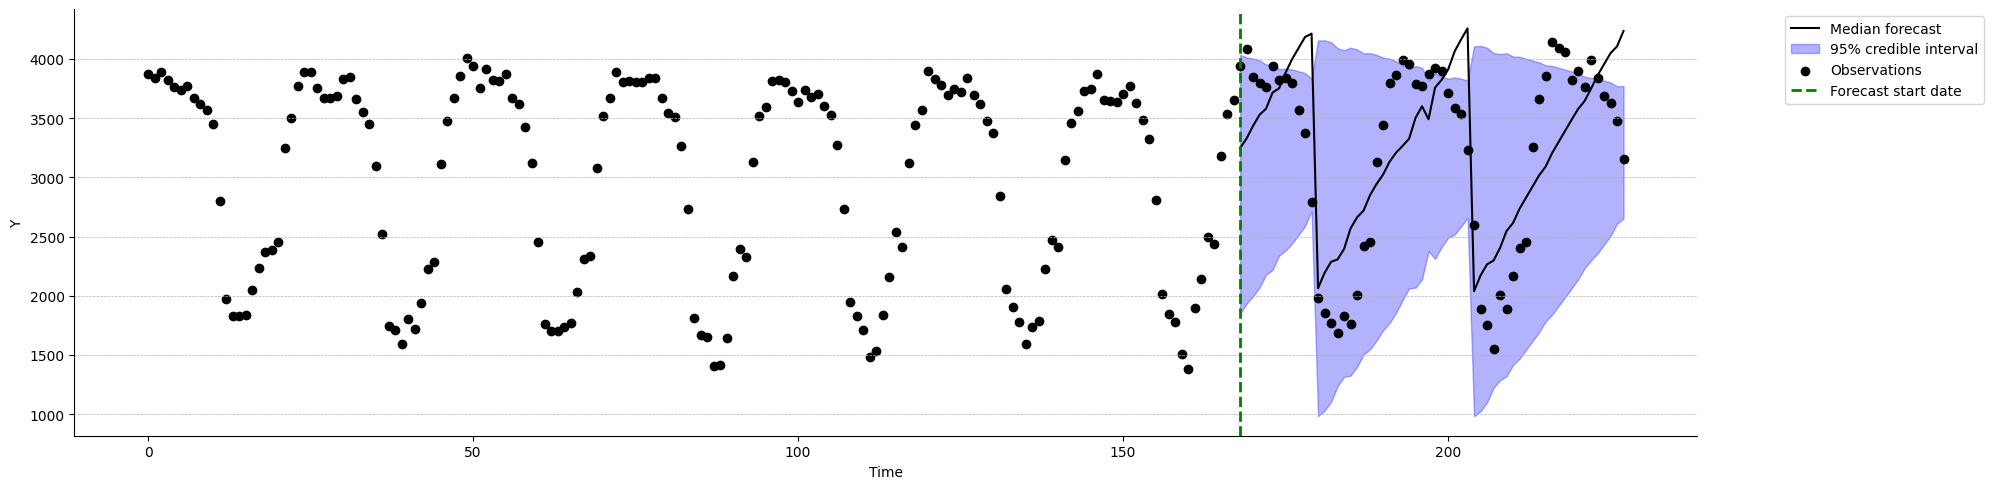

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [37]:
y_true_plot = np.hstack((scaler_target.inverse_transform(ytest), yforecast_test))
plot_data_forecast(params, y_true_plot, None, 'MQRNN', 'median', y_pred)
plt.savefig("MQRNN.pdf", bbox_inches='tight')
files.download("MQRNN.pdf")

# **Compare Results**

In [50]:
result_all = pd.concat([result_deepfactor, result_deepar, result_mqrnn]).pivot(index = 'Model', columns = 'Metric', values = 'Value')
result_all = result_all.transform(np.sort)

In [51]:
result_all

Metric,mae,mape,mase,mse,rmsse
Model,,,,,
Deep AR,132.735021,4.384458,0.625958,27032.847683,0.566409
Deep Factor,204.955897,7.373291,0.966540,83014.587531,0.992570
MQRNN,474.616956,16.574688,2.238220,303922.457194,1.899177
